# LSG Assignment

In this assignment we use decision trees to look at which variables affected people's survival on the Titanic. Let's load the data.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.metrics import confusion_matrix

In [2]:
titanic = pd.read_csv('../data/titanic.csv', sep = ',', header = 0)
titanic.columns = titanic.columns.str.lower() # use all lower case column names
orig=titanic.copy()
orig.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
orig.loc[orig.cabin.isnull()].survived.sum()

206

The data consists of categorical features sech as `pclass`, `sex`, `sibsp`, `parch`, numeric features such as `fare`, and features that should be unique or almost unique per row such as `passengerid`, `name`, `cabin` and `ticket`.

Prior to training, you will need to make decisions about the following:

- which features should we keep in the model? <span style="color:red" float:right>[5 point]</span>
- what are some ways we may need to clean the data? <span style="color:red" float:right>[5 point]</span>
- what kind of feature engineering should we consider doing with the features we keep? <span style="color:red" float:right>[5 point]</span>

Go through the above steps to get the data ready for analysis.

## Answers
- which features should we keep in the model? 

Based on my limited knowledge and research of the titanic disaster i believe that pclass (ticket class), sex, age, the existence or siblings/spouse/parents/children of the passenger, and i have created a feature for the deck level for each passenger. I do not believe the passengerId, name, fare, or the city in which they embarked from is important. However after testing and accounting for fare per person appears to have a positive effect on the models AUC so i am opting to leave it in.

- what are some ways we may need to clean the data? 

We first need to drop the features listed above that are "not important". Then we need to see if there are any blanks(NaN) and replace them or remove the row. For age i decided to use the median as a replacement value as both the mean and median are similar at high 20s the mode is slightly lower at 24 but this indicates that the ages are relatively evenly distributed. Additionally we want to change the integer values from floats to int for the decision tree. Additionally for the fare we have to convert it to a per person under the assumption that each parent/child/spouse/sibling is on the same ticket and being charged the same rate.

- what kind of feature engineering should we consider doing with the features we keep? 

To determine the deck level of each passenger i extracted the letter out of each cabin number to locate the passengers vertically on the ship. Due to the high number of NaNs with this feature i opted to use a random choice based on the distribution of known cabin data. This is a better solution than just using the most common deck level(C) to fill approximately 700 out of 900 values.

In [4]:
titanic.isnull().values.any()

True

In [5]:
print('The max age is', titanic.age.max(), 'the min age is', titanic.age.min(), 'the mean age is', titanic.age.mean(),'the median age is', titanic.age.median(),'the mode age is', titanic.age.mode()[0])

The max age is 80.0 the min age is 0.42 the mean age is 29.69911764705882 the median age is 28.0 the mode age is 24.0


In [6]:
titanic.dtypes

passengerid      int64
survived         int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

In [7]:
## your code goes here
titanic['deck']=titanic.cabin.str[:1] # get the deck from cabin number

## replacing blank deck values using the distribution of the existing known values
dist=titanic.deck.value_counts(normalize=True) #determine the distribution of the existing deck levels
missing= titanic.deck.isnull() # create a df for the deck values that are NaN
titanic.loc[missing,'deck']=np.random.choice(dist.index, size=len(titanic[missing]),p=dist.values) # making a random choice between the deck options to fill in the NaN spaces
## cleaning/removing remaining NaNs in the df
drop = ['passengerid','name','ticket','cabin','embarked'] # create list of features to drop
titanic.drop(drop, axis=1,inplace=True) # drop columns in place
titanic.loc[titanic.loc[:, "age"].isna(), "age"] = titanic['age'].median() # fill in blank age values with the mean

titanic['age']=titanic['age'].astype(int) #converting float to integer as age is an int
titanic['fare']=titanic['fare']/(1+titanic['sibsp']+titanic['parch']) #turning the fare into a per person number to account for number of children/spouse/parents on ticket.
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,deck
0,0,3,male,22,1,0,3.62500,D
1,1,1,female,38,1,0,35.64165,C
2,1,3,female,26,0,0,7.92500,B
3,1,1,female,35,1,0,26.55000,C
4,0,3,male,35,0,0,8.05000,B


In [8]:
titanic.dtypes

survived      int64
pclass        int64
sex          object
age           int32
sibsp         int64
parch         int64
fare        float64
deck         object
dtype: object

In [9]:
titanic.isnull().values.any()

False

- Train a decision tree classifier to predict survival using a good mix of categorical and numeric features in the data. You will need to decide if one-hot-encoding is needed for the categorical features, and if the numeric features should be normalized. <span style="color:red" float:right>[10 point]</span>

## Answers
To further prepare the data for the model I one-hot encoded the three categorical features(pclass, sex, and deck). With sex being a binary video we can drop the sex_female column to attempt to reduce the sparsity of our data frame. However with pclass and deck we assume that the increase in sparsity of our data is worth the trade off for more useful information(class and vertical location). Decision trees use > or < to make choices so there is no point in normalizing our numerical values.

In [10]:
## your code goes here
# one hot encode sex and deck
CategoricalColumns = ['pclass','sex','deck'] # designate columne to one_hot encode
onehot = OneHotEncoder(sparse = False, drop='if_binary') # define encoder and tell it to drop the second column if it's binary
onehot.fit(titanic[CategoricalColumns]) # fit encoder
onehot_col_names = onehot.get_feature_names(CategoricalColumns) # get column names from encoder
TitanicCategories = pd.DataFrame(onehot.transform(titanic[CategoricalColumns]), columns = onehot_col_names) # create new dataframe 
titanic[onehot_col_names]=TitanicCategories # combine dataframes
drop = ['pclass','sex','deck'] # create list of features to drop
titanic.drop(drop, axis=1,inplace=True) # drop columns in place again now that they've been one_hot encoded
titanic.head() #display

,survived,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_male,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T
0,0,22,1,0,3.62500,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,38,1,0,35.64165,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,26,0,0,7.92500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,35,1,0,26.55000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,35,0,0,8.05000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## I unfortunately couldn't get JC's solution to work for me. Sorry for the wait Cuong.

In [11]:
conda install -c anaconda graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [12]:
graphviz_path = '~/../../opt/conda/pkgs/graphviz-2.47.0-h93c640b_0/lib/graphviz'

def show_tree(out_name, model, feature_names):
    dotfile = open(out_name + ".dot", 'w')
    tree.export_graphviz(model, out_file = dotfile, filled = True, rounded = True, feature_names = feature_names)
    dotfile.close()

    os.environ["PATH"] += os.pathsep + graphviz_path
    os.system('dot -Tpng {}.dot -o {}.png'.format(out_name, out_name))

    return(Image(filename = out_name + '.png', width = 500, height = 500))

In [13]:
# Classification Accuracy Measures

# Packages for classification accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

# The following method determines and presents the following accuracy measures:
# Confusion Matrix
# Accuracy
# Precision
# Recall
# F1-score
# ROC
# AUC of ROC
def ClassificationAccuracy(actualTestOutcomes, predicted_probabilities, ClassThreshold = 0.5, title = ""):
    # Thresholded Accuracy Measures
    
    predicted_classes = 1*(predicted_probabilities > ClassThreshold)
    cm = confusion_matrix(actualTestOutcomes, predicted_classes)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision, recall, fscore, support = precision_recall_fscore_support(actualTestOutcomes, predicted_classes)
    ConfusionPresent = (
        '                       Survived  Died\n' +
        'predict Surv:     ' + str(tp) + "       " + str(fp) + "\n" + 
        'predict Died:     ' + str(fn) + "       " + str(tn))
    accuracyMetrics = (
        "\nAccuracy: %0.2f" % accuracy +
        "\nPrecision: %0.2f" % precision[1] + 
        "\nRecall: %0.2f" % recall[1] + 
        "\nF1-score: %0.2f" % fscore[1])
    
    # ROC
    fpr, tpr, probability_thresholds = roc_curve(actualTestOutcomes, predicted_probabilities)
    AUC_metric = auc(fpr, tpr)

    plt.rcParams["figure.figsize"] = [6, 4]
    plt.figure()
    plt.title('Classification Accuracies  ' + title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot(fpr, tpr, lw=3, label='ROC curve (AUC = %0.2f)' % AUC_metric)
    plt.legend(loc="lower center")
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--') # reference line for random classifier modified to prevent depreciation
    #plt.text(x=0.1, y=0.0, s="AUC: %0.2f" % AUC_metric)
    plt.text(x=0.70, y=0.45, s=accuracyMetrics)
    plt.text(x=0.45, y=0.2, s=ConfusionPresent)
    plt.show()
    return None

# TrainAndTestWrapper combines model training and model testing
def TrainAndTestWrapper(model, X_train, y_train, X_test, y_test, title=""):
    model.fit(X_train, y_train) 
    test_probabilities = model.predict_proba(X_test)[:,1]
    ClassificationAccuracy(y_test, test_probabilities, title=title)

In [14]:
X = titanic.drop(columns = "survived")
Y = titanic["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 99)#code copied from lab

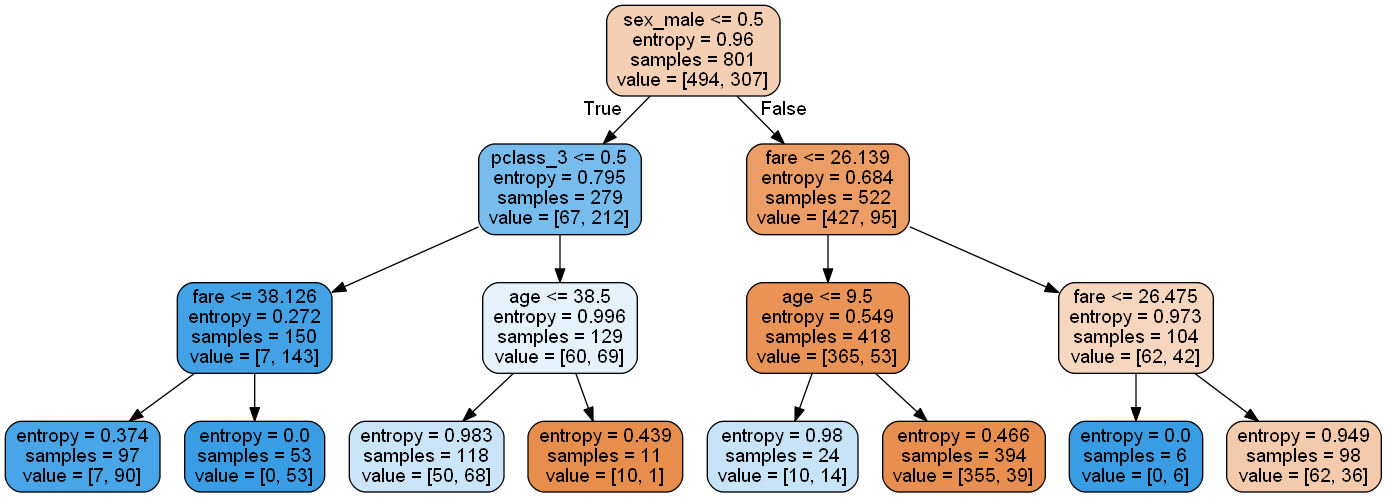

In [15]:
## your code goes here
tree_labelencoder = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
tree_labelencoder.fit(X_train, y_train)
show_tree('titanic_tree_labelencoder', tree_labelencoder, X_train.columns)

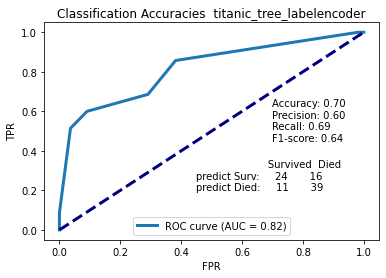

In [317]:
TrainAndTestWrapper(tree_labelencoder, X_train, y_train, X_test, y_test, title="titanic_tree_labelencoder")

### Conclusion
Our vanilla decision tree with no hyper parameter tuning has an AUC of 0.82 which is a good start and we'll see how/if we can improve it below.

Train a few different models (with different hyper-parameters) and report the following about your results?

- should we consider accuracy or another measure of performance? <span style="color:red" float:right>[2 point]</span>
- what is the best performance we get? <span style="color:red" float:right>[1 point]</span>
- what are the most important features to predict survival? <span style="color:red" float:right>[2 point]</span>

## Answers
- should we consider accuracy or another measure of performance?

Per the class accuracy is not a good way to evaluate the models performance as it requires an equal number of samples belonging to each class to work well. Which based on the discrepancy between survived and not we do not have in this dataset. The Area Under Curve(AUC) is one of the most widely used metrics and refers to the area under a receiver operating characteristic graph. This metric is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example.
- what is the best performance we get?

The best performance we can get using the following hyper parameters criterion='gini',max_depth=4 resulted in a high AUC of 0.86 but generally stayed around 0.85/0.84.
- what are the most important features to predict survival?

Based on the decision tree image the top three features that impacted the survival probability are sex_male=0(e.g. female), pclass_3, and deck_A. These are followed by age and number of siblings.

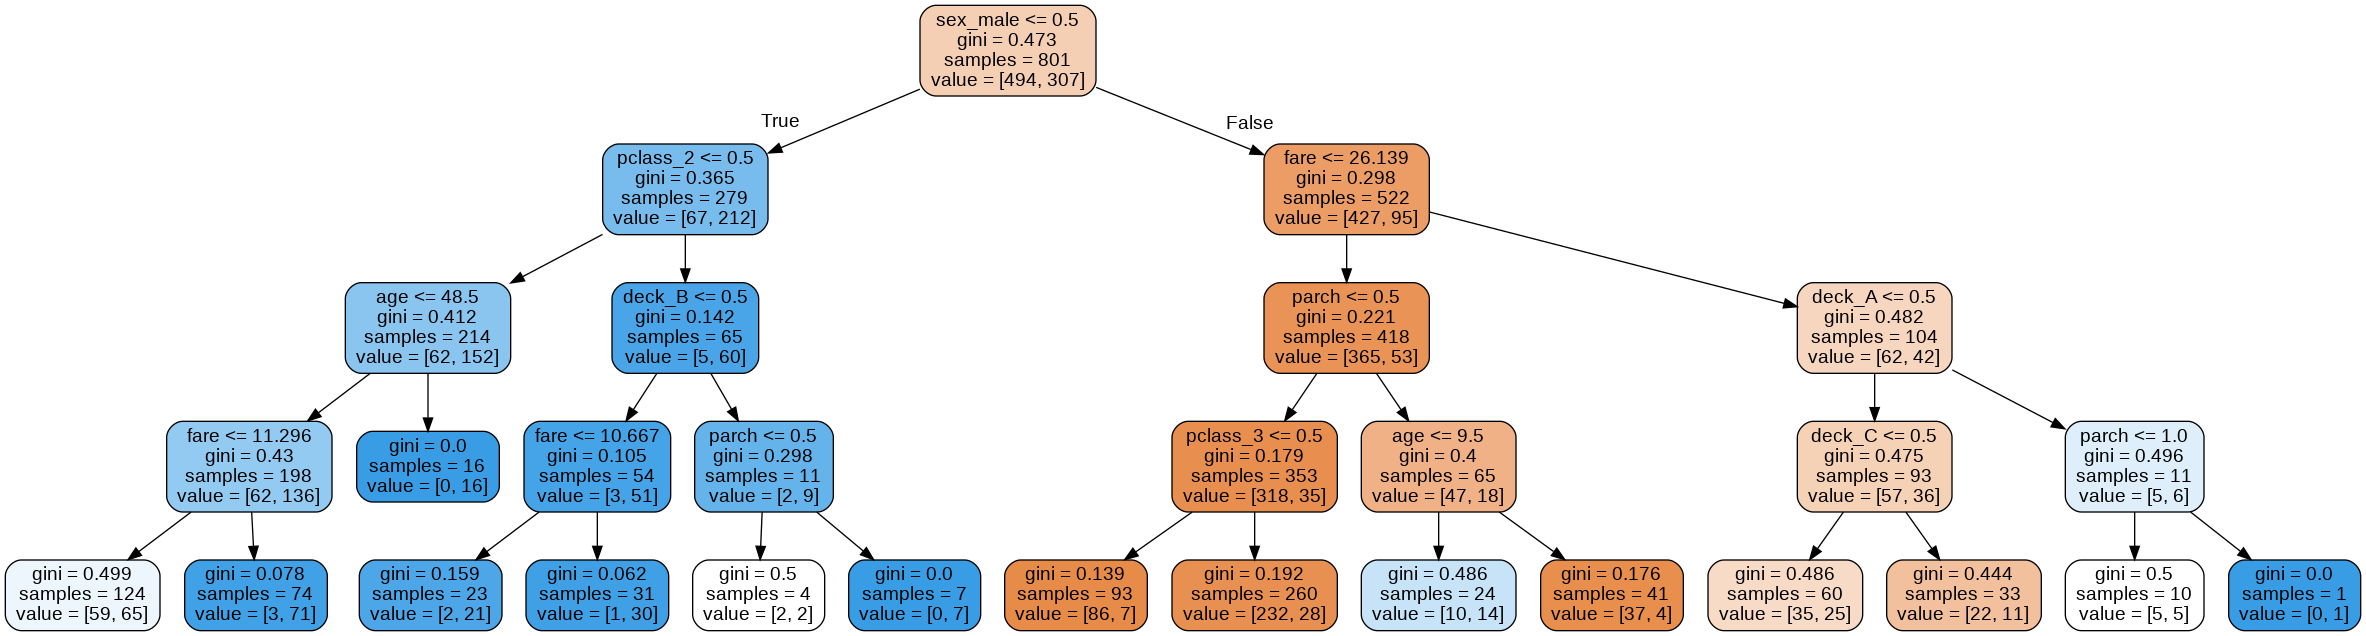

In [318]:
## your code goes here
tree_labelencoder_MF = DecisionTreeClassifier(criterion = 'gini',max_depth=4,max_features="sqrt")
tree_labelencoder_MF.fit(X_train, y_train)
show_tree('titanic_tree_labelencoder_maxfeatures', tree_labelencoder_MF, X_train.columns)

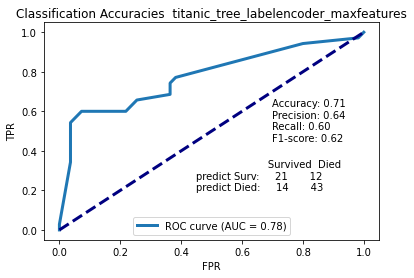

In [319]:
TrainAndTestWrapper(tree_labelencoder_MF, X_train, y_train, X_test, y_test, title="titanic_tree_labelencoder_maxfeatures")

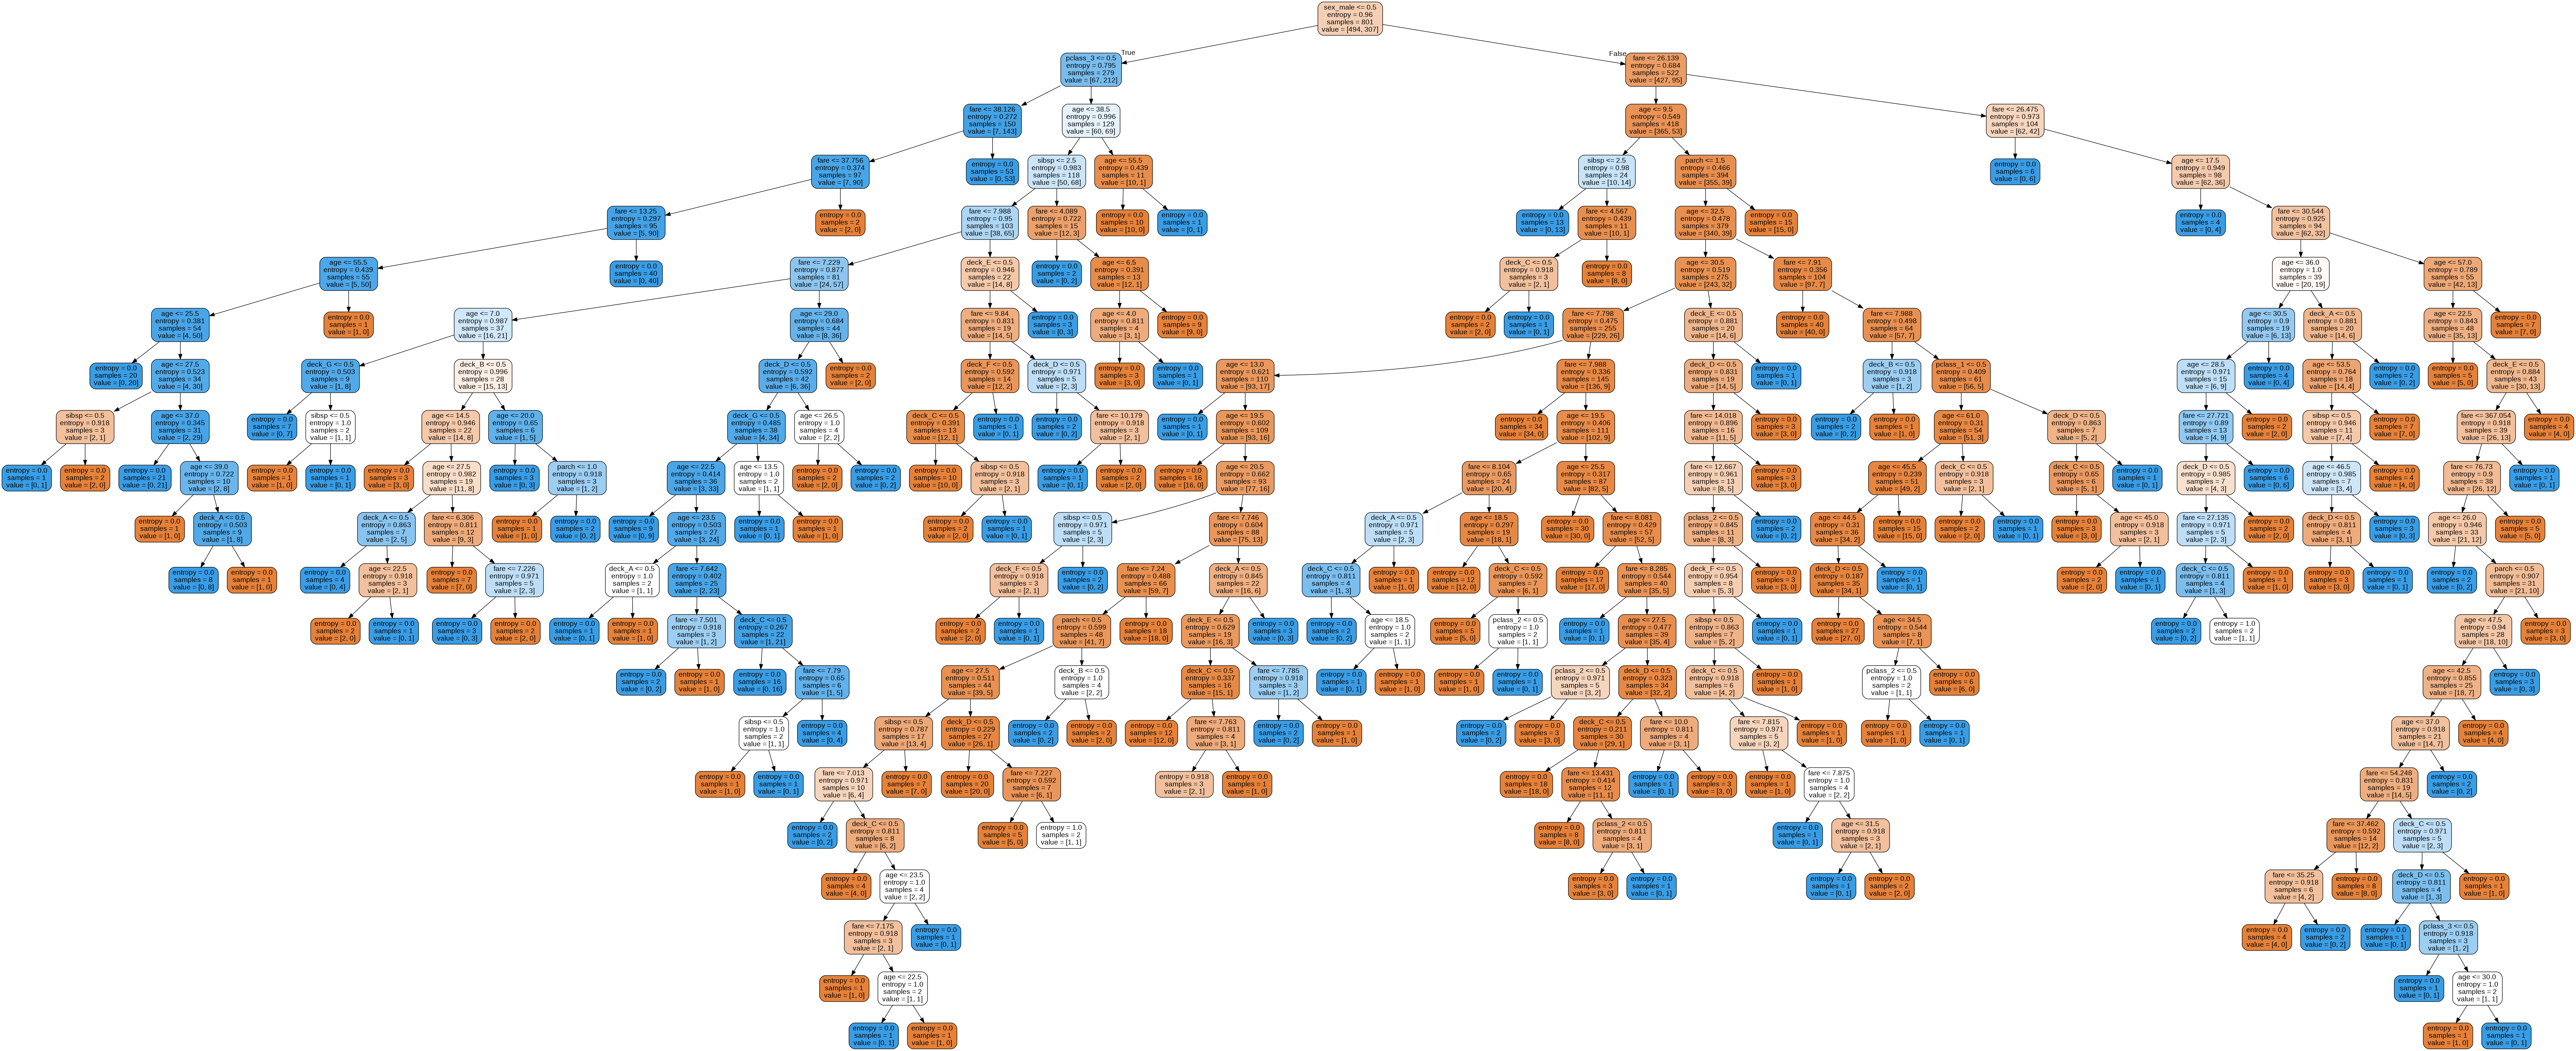

In [320]:
## your code goes here
tree_labelencoder_deep = DecisionTreeClassifier(criterion = 'entropy',max_depth=100)
tree_labelencoder_deep.fit(X_train, y_train)
show_tree('titanic_tree_labelencoder_deep', tree_labelencoder_deep, X_train.columns)

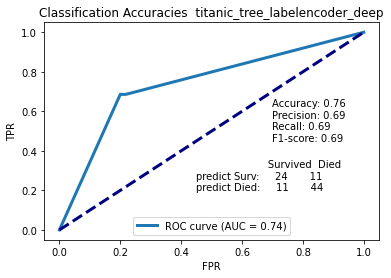

In [321]:
TrainAndTestWrapper(tree_labelencoder_deep, X_train, y_train, X_test, y_test, title="titanic_tree_labelencoder_deep")

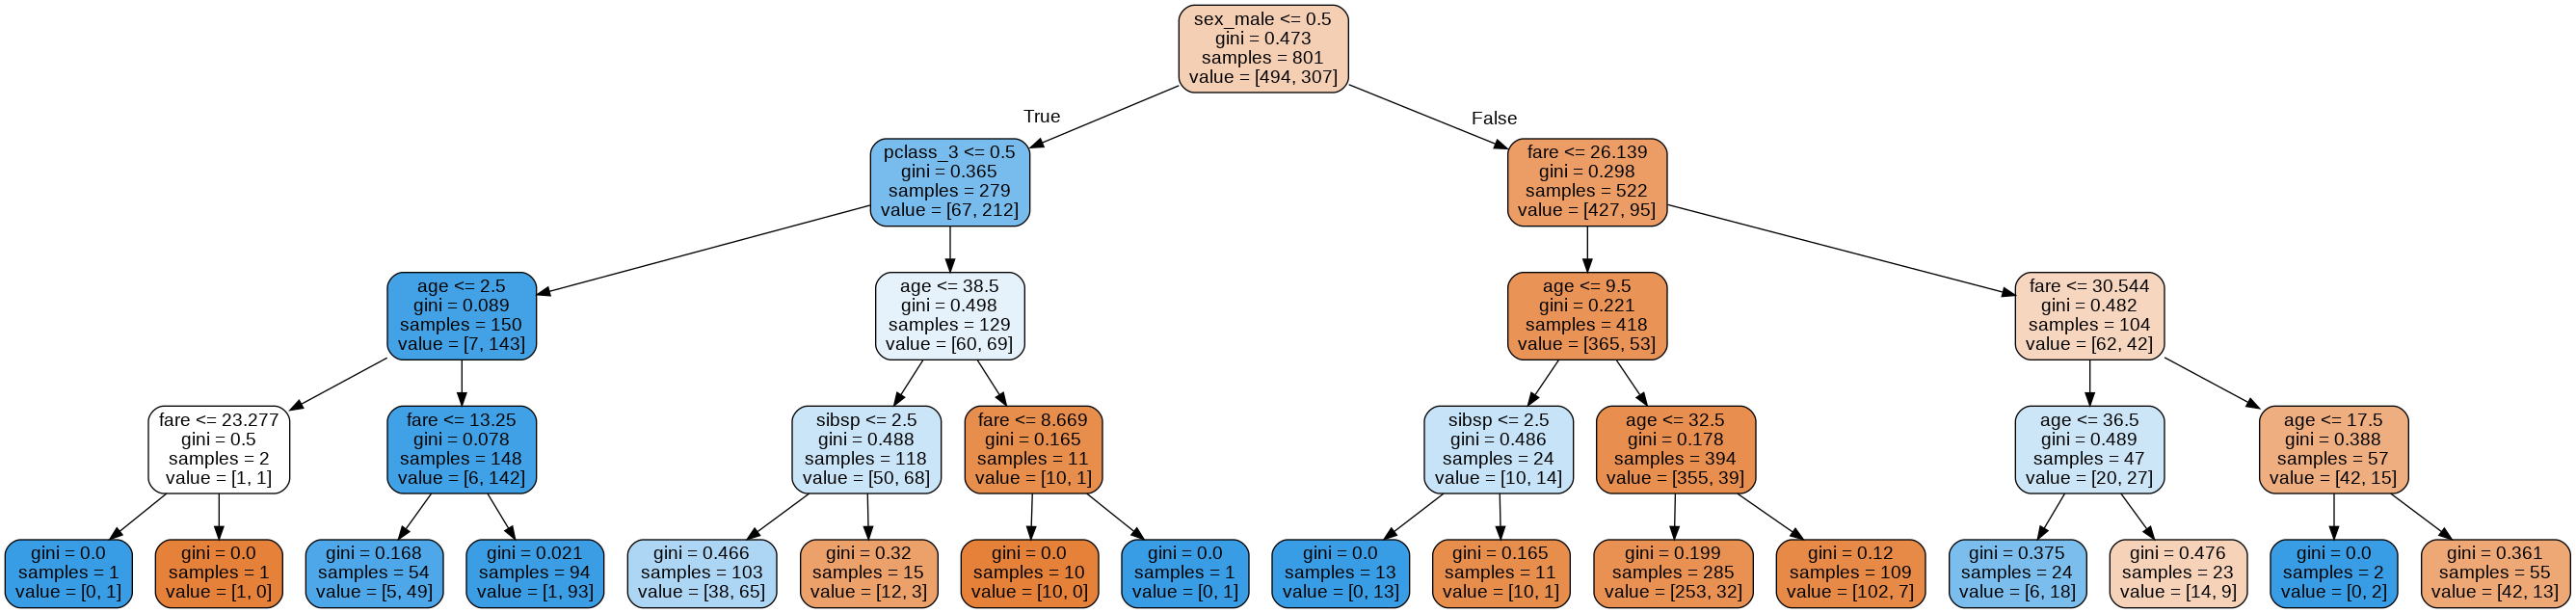

In [322]:
## your code goes here
tree_labelencoder_final = DecisionTreeClassifier(criterion='gini',max_depth=4)
tree_labelencoder_final.fit(X_train, y_train)
show_tree('titanic_tree_labelencoder_final', tree_labelencoder_final, X_train.columns)

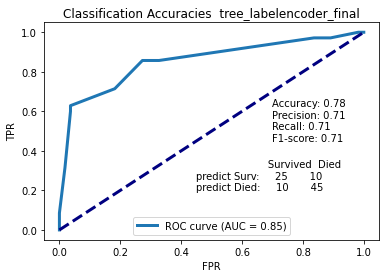

In [323]:
TrainAndTestWrapper(tree_labelencoder_final, X_train, y_train, X_test, y_test, title="tree_labelencoder_final")

In [324]:
orig.survived.sum()/len(orig.survived)

0.3838383838383838

### Conclusion 
The decision tree does not need a large depth to perform well. It appears that any depth beyond ~4 is detrimental to the model. In addition it is likely to over train the model and would not allow it to be applied to new data well.

### End of exercise